# Crack Detection with Pytorch

## Julian Ariza

## Data Loading

In [1]:
from zipfile import ZipFile

In [2]:
#!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/concrete_crack_images_for_classification.zip -P C:/Users/Julian/Documents/GitHub/CrackDetectionPytorch/data

In [3]:
#directory = 'C:/Users/Julian/Documents/GitHub/CrackDetectionPytorch/data/concrete_crack_images_for_classification.zip'
#with ZipFile(directory, 'r') as zipObj:
#    zipObj.extractall('data')

In [4]:
from PIL import Image
from matplotlib.pyplot import imshow
import pandas
import matplotlib.pylab as plt
import os
import glob
import torch
import numpy as np

In [5]:
torch.cuda.is_available()
device = torch.device('cuda:0')

In [6]:
def show_data(data_sample):
    image = Image.open(data_sample)
    plt.imshow(image)
    plt.title(data_sample)
    plt.show()

In [7]:
directory = 'C:/Users/Julian/Documents/GitHub/CrackDetectionPytorch/data/'
negative = 'Negative'
positive = 'Positive'

In [8]:
negative_path = os.path.join(directory,negative)
positive_path = os.path.join(directory,positive)

In [9]:
negative_files = [os.path.join(negative_path, file) for file in os.listdir(negative_path) if file.endswith('.jpg')]
negative_files.sort()
positive_files = [os.path.join(positive_path, file) for file in os.listdir(positive_path) if file.endswith('.jpg')]
positive_files.sort()

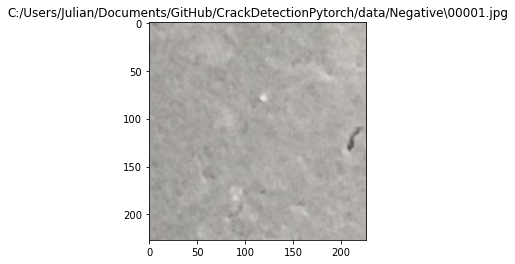

In [10]:
show_data(negative_files[0])

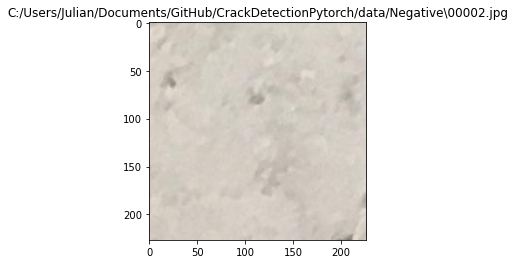

In [11]:
show_data(negative_files[1])

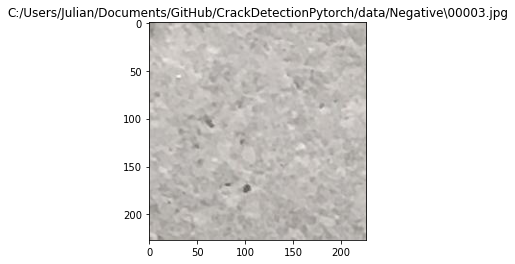

In [12]:
show_data(negative_files[2])

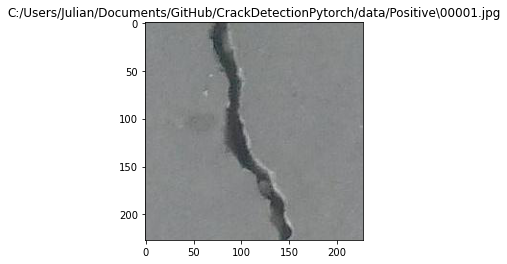

In [13]:
show_data(positive_files[0])

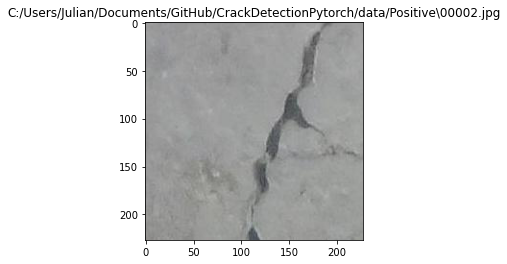

In [14]:
show_data(positive_files[1])

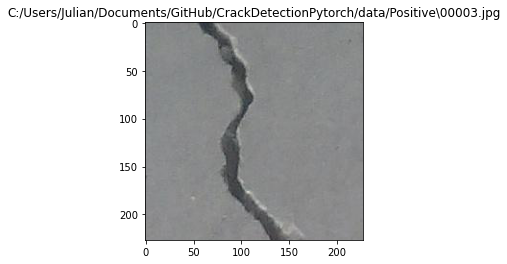

In [15]:
show_data(positive_files[2])

## Dataset Object

In [16]:
number_of_samples = len(negative_files) + len(positive_files)
y = torch.zeros([number_of_samples])
y = y.type(torch.LongTensor)
y[::2] = 1
y[1::2] = 0
y

tensor([1, 0, 1,  ..., 0, 1, 0])

In [17]:
all_files = []
for positive, negative in zip(positive_files, negative_files):
    all_files.append(positive)
    all_files.append(negative)

all_files[0:4]

['C:/Users/Julian/Documents/GitHub/CrackDetectionPytorch/data/Positive\\00001.jpg',
 'C:/Users/Julian/Documents/GitHub/CrackDetectionPytorch/data/Negative\\00001.jpg',
 'C:/Users/Julian/Documents/GitHub/CrackDetectionPytorch/data/Positive\\00002.jpg',
 'C:/Users/Julian/Documents/GitHub/CrackDetectionPytorch/data/Negative\\00002.jpg']

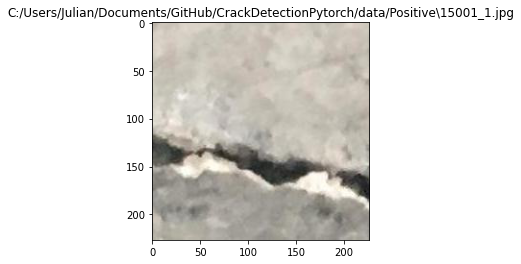

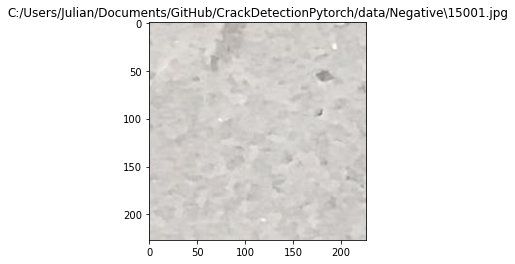

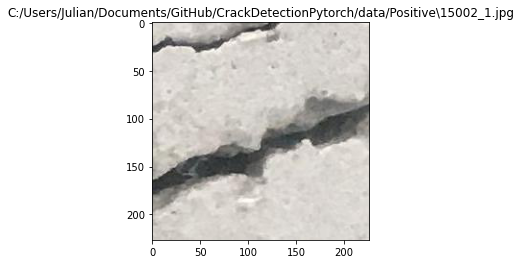

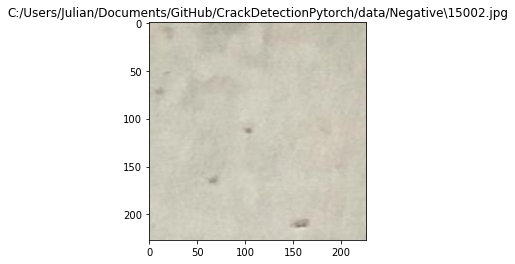

In [18]:
for label, file in zip(y,all_files[30000:30004]):    
    show_data(file)

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(all_files, y, test_size = 0.25, random_state = 0)

In [20]:
X_train[0:4]

['C:/Users/Julian/Documents/GitHub/CrackDetectionPytorch/data/Positive\\09307.jpg',
 'C:/Users/Julian/Documents/GitHub/CrackDetectionPytorch/data/Positive\\17402_1.jpg',
 'C:/Users/Julian/Documents/GitHub/CrackDetectionPytorch/data/Positive\\15458_1.jpg',
 'C:/Users/Julian/Documents/GitHub/CrackDetectionPytorch/data/Negative\\09743.jpg']

In [21]:
y_train[0:4]

tensor([1, 1, 1, 0])

In [22]:
from torch.utils.data import Dataset
class Dataset(Dataset):
    def __init__(self, transform = None, train = True):
        directory = 'C:/Users/Julian/Documents/GitHub/CrackDetectionPytorch/data/'
        positive = 'Positive'
        negative = 'Negative'
        
        positive_path = os.path.join(directory, positive)
        negative_path = os.path.join(directory, negative)
        positive_files = [os.path.join(positive_path, file) for file in os.listdir(positive_path) if file.endswith('.jpg')]
        positive_files.sort()
        negative_files = [os.path.join(negative_path, file) for file in os.listdir(negative_path) if file.endswith('.jpg')]
        negative_files.sort()
        
        self.all_files = [None]*number_of_samples
        self.all_files[::2] = positive_files
        self.all_files[1::2] = negative_files
        
        self.transform = transform
        
        self.labels = torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.labels[::2] = 1
        self.labels[1::2] = 0
        
        X_train, X_test, y_train, y_test = train_test_split(self.all_files, self.labels, test_size = 0.25, random_state = 0)
        
        #if train:
        #    self.X = X_train
        #    self.y = y_train
        #    self.len = len(self.y)
        #else:
        #    self.X = X_test
        #    self.y = y_test
        #    self.len = len(self.y)            
            
        if train:
            self.X=self.all_files[0:30000]
            self.y=self.labels[0:30000]
            self.len=len(self.y)
        else:
            self.X=self.all_files[30000:]
            self.y=self.labels[30000:]
            self.len=len(self.y)
            
    def __len__ (self):
        return self.len
    
    def __getitem__(self, idx):
        image = Image.open(self.X[idx])
        label = self.y[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

## Transform Object

In [23]:
import torchvision.transforms as transforms
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

In [24]:
train = Dataset(transform = transform, train = True)
test = Dataset(transform = transform, train = False)

In [25]:
train[0][0].shape

torch.Size([3, 227, 227])

In [26]:
size_of_image = 3*227*227
size_of_image

154587

In [27]:
import torch.nn as nn
class SoftMax(nn.Module):
    def __init__(self, input_size, output_size):
        super(SoftMax, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        z = self.linear(x)
        return z

In [28]:
from torch.utils.data import DataLoader as DataLoader
model = SoftMax(size_of_image, 2)
model.to(device)
learning_rate = 0.1
momentum_term = 0.1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = momentum_term)
train_loader = DataLoader(dataset = train, batch_size = 1000)

In [29]:
print(model)
print(optimizer)

SoftMax(
  (linear): Linear(in_features=154587, out_features=2, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.1
    momentum: 0.1
    nesterov: False
    weight_decay: 0
)


In [30]:
torch.manual_seed(0)

In [31]:
import datetime
a = datetime.datetime.now()

loss_list = []
accuracy_list = []
N_test = len(test)

for epoch in range(5):
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        z = model(x.view(-1, size_of_image))
        loss = criterion(z, y)
        loss.backward()
        optimizer.step()

    correct = 0
    for x_test, y_test in test:
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        z = model(x_test.view(-1, size_of_image))
        _, yhat = torch.max(z.data, 1)
        correct += (yhat == y_test).sum().item()
    accuracy = correct / N_test
    loss_list.append(loss.data)
    accuracy_list.append(accuracy)
    b = datetime.datetime.now()
    c = b-a
    print(c.seconds)

452
599
741
887
1033


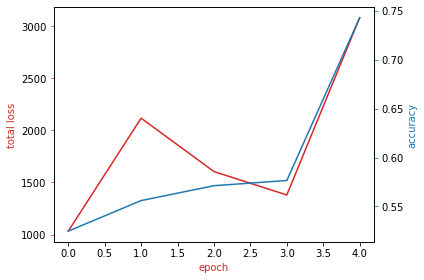

In [32]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_list,color=color)
ax1.set_ylabel('total loss',color=color)
ax1.set_xlabel('epoch',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.plot(accuracy_list, color=color)
ax2.set_ylabel('accuracy', color=color)  
ax2.set_xlabel('epoch',color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

In [33]:
max(accuracy_list)

0.7428

In [34]:
import torchvision.models as models
modelRes = models.resnet18(pretrained = True)

In [35]:
for param in modelRes.parameters():
    param.requires_grad = False

In [36]:
modelRes.fc = nn.Linear(512, 2)
modelRes.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [37]:
composed = transforms.Compose([transforms.Resize(224), transforms.ToTensor(), transforms.Normalize(mean, std)])
train_dataset = Dataset(transform = composed, train = True)
validation_dataset = Dataset(transform = composed, train = False)
train_loader = DataLoader(dataset = train_dataset, batch_size = 15)
validation_loader = DataLoader(dataset = validation_dataset, batch_size = 10)

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([parameters for parameters in modelRes.parameters() if parameters.requires_grad], lr = 0.003)

In [39]:
import time
a = datetime.datetime.now()

N_epochs = 1
lossRes_list = []
accuracyRest_list = []
n_validation = len(validation_dataset)

for epoch in range(N_epochs):
    loss_sublist = []
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        modelRes.train()
        optimizer.zero_grad()
        z = modelRes(x)
        loss = criterion(z, y)
        loss_sublist.append(loss.data.item())
        loss.backward()
        optimizer.step()
    lossRes_list.append(np.mean(loss_sublist))
    
    correct = 0
    for x_test, y_test in validation_loader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        modelRes.eval()
        z = modelRes(x_test)
        _, yhat = torch.max(z.data, 1)
        correct += (yhat == y_test).sum().item()
    accuracy = correct/n_validation
    accuracyRest_list.append(accuracy)
    b = datetime.datetime.now()
    c = b-a
    print(c.seconds)
    time.sleep(300)
    


710


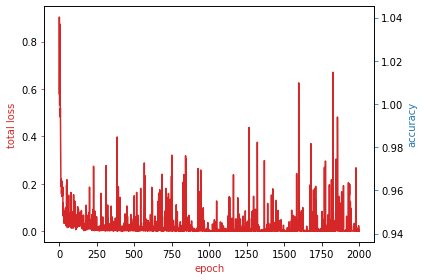

In [41]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_sublist,color=color)
ax1.set_ylabel('total loss',color=color)
ax1.set_xlabel('epoch',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.plot(accuracyRest_list, color=color)
ax2.set_ylabel('accuracy', color=color)  
ax2.set_xlabel('epoch',color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()